In [ ]:
import os
import random
from datetime import datetime, timedelta
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def plot_candlestick_with_bollinger_minimal_with_volume_fixed(
    symbol='SPY', 
    start_date=None, 
    end_date=None, 
    window=20, 
    num_std=2, 
    use_trendline=False, 
    use_bollinger=True,
    show=True
):
    """
    주식 심볼의 캔들스틱 차트와 거래량, 볼린저 밴드를 최소한의 형태로 시각화하며,
    y축을 오른쪽으로 이동시킨 함수.
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    if start_date is None:
        start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=180)).strftime('%Y-%m-%d')

    calc_start_date = (datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=window + 5)).strftime('%Y-%m-%d')
    
    # 데이터 가져오기
    ticker = yf.Ticker(symbol)
    data = ticker.history(start=calc_start_date, end=end_date)
    
    # 볼린저 밴드 계산
    data['MA20'] = data['Close'].rolling(window=window).mean()
    data['Upper'] = data['MA20'] + (data['Close'].rolling(window=window).std() * num_std)
    data['Lower'] = data['MA20'] - (data['Close'].rolling(window=window).std() * num_std)

    if use_trendline:
        x = range(len(data))
        y = data['Close'].values
        fit = np.polyfit(x, y, 1)
        data['Trendline'] = fit[0] * x + fit[1]

    plot_data = data[data.index >= start_date].copy()

    # 추가 플롯 설정
    add_plots = []
    if use_bollinger:
        add_plots += [
            mpf.make_addplot(plot_data['MA20'], color='green', width=1.5),
            mpf.make_addplot(plot_data['Upper'], color='orange', width=1.2),
            mpf.make_addplot(plot_data['Lower'], color='orange', width=1.2)
        ]
    if use_trendline:
        add_plots.append(mpf.make_addplot(plot_data['Trendline'], color='blue', linestyle='-', width=1.5))
    
    # 차트 스타일 설정 (y축 오른쪽으로 이동)
    style = mpf.make_mpf_style(
        marketcolors=mpf.make_marketcolors(
            up='red', down='blue',
            edge='inherit',
            wick='inherit',
            volume='in'
        ),
        gridstyle=':', 
        y_on_right=True  # y축을 오른쪽으로 설정
    )
    
    # 캔들스틱 차트와 거래량 포함 시각화
    fig, axes = mpf.plot(
        plot_data, 
        type='candle', 
        style=style,
        title='',  # 제목 제거
        ylabel='',  # y축 레이블 제거
        volume=True,  # 거래량 포함
        addplot=add_plots,
        returnfig=True
    )
    
    # x축, y축, 제목 등 제거
    for ax in axes:
        ax.set_xlabel('')  # x축 레이블 제거
        ax.set_ylabel('')  # y축 레이블 제거
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # x축 눈금 제거
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  # 왼쪽 y축 제거
        ax.tick_params(axis='y', which='both', right=True, labelright=False)  # 오른쪽 y축 추가

    
    if show:
        plt.tight_layout()
        plt.show()

    return fig, axes

def driver_save_candlestick_charts(symbol_list, output_folder='out', use_trendline=False, use_bollinger=False):
    """
    주어진 미국 주요 빅테크 주식 심볼 리스트에 대해 시작일을 랜덤으로 설정하여 
    2주간의 정보를 캔들스틱 차트로 저장하는 driver 함수.

    Parameters:
    - symbol_list: 주식 심볼 리스트 (예: ['AAPL', 'MSFT', 'GOOGL'])
    - output_folder: 저장할 폴더 경로 (기본값: 'out')
    - use_trendline: 추세선 추가 여부 (기본값: True)
    - use_bollinger: 볼린저 밴드 추가 여부 (기본값: True)
    """
    # 저장 폴더 생성
    os.makedirs(output_folder, exist_ok=True)

    # 오늘 날짜 기준으로 데이터 생성
    today = datetime.now()

    for symbol in symbol_list:
        # 랜덤 시작일 설정 (2024년 내의 임의 날짜)
        random_start_date = today - timedelta(days=random.randint(14, 300))
        start_date = random_start_date.strftime('%Y-%m-%d')
        end_date = (random_start_date + timedelta(days=14)).strftime('%Y-%m-%d')  # 2주간 데이터
        
        # 캔들스틱 차트 생성
        try:
            fig, axes = plot_candlestick_with_bollinger_minimal_with_volume_fixed(
                symbol=symbol,
                start_date=start_date,
                end_date=end_date,
                use_trendline=use_trendline,
                use_bollinger=use_bollinger,
                show=False
            )
            
            # 저장 경로 설정
            output_path = os.path.join(output_folder, f'{symbol}_{start_date}_to_{end_date}.png')
            
            # 그림 저장
            fig.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"Saved chart for {symbol} ({start_date} to {end_date}) at {output_path}")
            plt.close()
        except Exception as e:
            print(f"Error generating chart for {symbol}: {e}")

In [3]:
# 주요 빅테크 주식 심볼 리스트
dataset_symbols={
    'big_tech_symbols' : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'ORCL', 'IBM','AMD'],
    'my_favors' : ['SOXL','IONQ','AVGO','CRM','PLTR','DPST','SHOC','MU','QQQ','SPY','QCOM'],
    'drops' : ['SMCI','INTC'],
    'inverses' : ['SOXS','NVD']
}

# Driver 실행
for k,s_list in dataset_symbols.items():
    driver_save_candlestick_charts(s_list)
    break

Saved chart for AAPL (2024-07-19 to 2024-08-02) at out\AAPL_2024-07-19_to_2024-08-02.png
Saved chart for MSFT (2024-10-31 to 2024-11-14) at out\MSFT_2024-10-31_to_2024-11-14.png
Saved chart for GOOGL (2024-03-09 to 2024-03-23) at out\GOOGL_2024-03-09_to_2024-03-23.png
Saved chart for AMZN (2024-04-05 to 2024-04-19) at out\AMZN_2024-04-05_to_2024-04-19.png
Saved chart for META (2024-04-18 to 2024-05-02) at out\META_2024-04-18_to_2024-05-02.png
Saved chart for TSLA (2024-08-26 to 2024-09-09) at out\TSLA_2024-08-26_to_2024-09-09.png
Saved chart for NVDA (2024-06-19 to 2024-07-03) at out\NVDA_2024-06-19_to_2024-07-03.png
Saved chart for NFLX (2024-10-09 to 2024-10-23) at out\NFLX_2024-10-09_to_2024-10-23.png
Saved chart for ORCL (2024-05-07 to 2024-05-21) at out\ORCL_2024-05-07_to_2024-05-21.png
Saved chart for IBM (2024-03-28 to 2024-04-11) at out\IBM_2024-03-28_to_2024-04-11.png
Saved chart for AMD (2024-10-14 to 2024-10-28) at out\AMD_2024-10-14_to_2024-10-28.png


### Gen

In [16]:
import numpy as np
import mplfinance as mpf
import yfinance as yf
from datetime import datetime, timedelta
import os
import random
import matplotlib.pyplot as plt

def plot_candlestick_with_sampling(
    symbol='SPY', 
    start_date=None, 
    end_date=None, 
    window=20, 
    num_std=2, 
    use_trendline=False,
    use_bollinger=True,
    sampling_mode='random',  # 'random' or 'last'
    num_samples=1,          # random 모드에서 사용될 샘플 개수
    is_target=False,        # target 이미지인지 여부
    show=True
):
    """
    주식 심볼의 캔들스틱 차트와 거래량을 시각화하며, sampling_mode에 따라 데이터를 비우는 함수.
    
    Parameters:
    - sampling_mode: 'random' (랜덤 위치 n개) 또는 'last' (마지막 인덱스)
    - num_samples: random 모드에서 비울 데이터 포인트 개수
    - is_target: True면 모든 데이터 표시, False면 일부 데이터 비움
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    if start_date is None:
        start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=180)).strftime('%Y-%m-%d')

    calc_start_date = (datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=window + 5)).strftime('%Y-%m-%d')
    
    # 데이터 가져오기
    ticker = yf.Ticker(symbol)
    data = ticker.history(start=calc_start_date, end=end_date)
    
    # 볼린저 밴드 계산
    data['MA20'] = data['Close'].rolling(window=window).mean()
    data['Upper'] = data['MA20'] + (data['Close'].rolling(window=window).std() * num_std)
    data['Lower'] = data['MA20'] - (data['Close'].rolling(window=window).std() * num_std)

    if use_trendline:
        x = range(len(data))
        y = data['Close'].values
        fit = np.polyfit(x, y, 1)
        data['Trendline'] = fit[0] * x + fit[1]

    plot_data = data[data.index >= start_date].copy()
    
    # input 이미지 생성 시 데이터 비우기
    if not is_target:
        if sampling_mode == 'random':
            # 랜덤하게 n개의 인덱스 선택
            total_points = len(plot_data)
            indices_to_remove = random.sample(range(total_points), min(num_samples, total_points))
            
            # 선택된 인덱스의 데이터 비우기
            for idx in indices_to_remove:
                plot_data.iloc[idx, :] = np.nan
                
        elif sampling_mode == 'last':
            # 마지막 인덱스의 데이터 비우기
            plot_data.iloc[-1, :] = np.nan

    # 추가 플롯 설정
    add_plots = []
    if use_bollinger:
        add_plots += [
            mpf.make_addplot(plot_data['MA20'], color='green', width=1.5),
            mpf.make_addplot(plot_data['Upper'], color='orange', width=1.2),
            mpf.make_addplot(plot_data['Lower'], color='orange', width=1.2)
        ]
    if use_trendline:
        add_plots.append(mpf.make_addplot(plot_data['Trendline'], color='blue', linestyle='-', width=1.5))
    
    # 차트 스타일 설정
    style = mpf.make_mpf_style(
        marketcolors=mpf.make_marketcolors(
            up='red', down='blue',
            edge='inherit',
            wick='inherit',
            volume='in'
        ),
        gridstyle=':', 
        y_on_right=True
    )
    
    # 캔들스틱 차트와 거래량 포함 시각화
    fig, axes = mpf.plot(
        plot_data, 
        type='candle', 
        style=style,
        title='',
        ylabel='',
        volume=True,
        addplot=add_plots,
        returnfig=True
    )
    
    # x축, y축, 제목 등 제거
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        ax.tick_params(axis='y', which='both', right=True, labelright=False)
    
    if show:
        plt.tight_layout()
        plt.show()

    return fig, axes

def driver_save_candlestick_charts(
    symbol_list,
    base_folder='data',
    use_trendline=False,
    use_bollinger=False,
    sampling_mode='random',
    num_samples=1
):
    """
    주어진 주식 심볼 리스트에 대해 input과 target 이미지를 생성하여 저장하는 함수.
    
    폴더 구조:
    data/
    ├── inputs/
    │   ├── random/
    │   │   ├── AAPL/
    │   │   ├── MSFT/
    │   │   └── ...
    │   └── last/
    │       ├── AAPL/
    │       ├── MSFT/
    │       └── ...
    └── targets/
        ├── random/
        │   ├── AAPL/
        │   ├── MSFT/
        │   └── ...
        └── last/
            ├── AAPL/
            ├── MSFT/
            └── ...
    
    Parameters:
    - symbol_list: 주식 심볼 리스트
    - base_folder: 기본 저장 폴더 (기본값: 'data')
    - sampling_mode: 'random' 또는 'last'
    - num_samples: random 모드에서 비울 데이터 포인트 개수
    """
    # 기본 폴더 생성
    input_base = os.path.join(base_folder, 'inputs')
    target_base = os.path.join(base_folder, 'targets')
    
    # 모드별 폴더 및 심볼별 하위 폴더 생성
    modes = ['random', 'last']
    for mode in modes:
        # inputs 폴더 구조 생성
        input_mode_folder = os.path.join(input_base, mode)
        for symbol in symbol_list:
            input_symbol_folder = os.path.join(input_mode_folder, symbol)
            os.makedirs(input_symbol_folder, exist_ok=True)
        
        # targets 폴더 구조 생성
        target_mode_folder = os.path.join(target_base, mode)
        for symbol in symbol_list:
            target_symbol_folder = os.path.join(target_mode_folder, symbol)
            os.makedirs(target_symbol_folder, exist_ok=True)
    
    # 오늘 날짜 기준으로 데이터 생성
    today = datetime.now()

    for symbol in symbol_list:
        # 랜덤 시작일 설정 (2024년 내의 임의 날짜)
        random_start_date = today - timedelta(days=random.randint(14, 300))
        start_date = random_start_date.strftime('%Y-%m-%d')
        end_date = (random_start_date + timedelta(days=14)).strftime('%Y-%m-%d')
        
        try:
            # 파일명 생성
            filename = f'{symbol}_{start_date}_to_{end_date}.png'
            
            # 'random' 모드로 이미지 생성
            fig, axes = plot_candlestick_with_sampling(
                symbol=symbol,
                start_date=start_date,
                end_date=end_date,
                use_trendline=use_trendline,
                use_bollinger=use_bollinger,
                sampling_mode='random',
                num_samples=num_samples,
                is_target=False,
                show=False
            )
            
            # random 모드 input 이미지 저장
            input_path = os.path.join(input_base, 'random', symbol, filename)
            fig.savefig(input_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # random 모드 target 이미지 저장
            fig, axes = plot_candlestick_with_sampling(
                symbol=symbol,
                start_date=start_date,
                end_date=end_date,
                use_trendline=use_trendline,
                use_bollinger=use_bollinger,
                is_target=True,
                show=False
            )
            
            target_path = os.path.join(target_base, 'random', symbol, filename)
            fig.savefig(target_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # 'last' 모드로 이미지 생성
            fig, axes = plot_candlestick_with_sampling(
                symbol=symbol,
                start_date=start_date,
                end_date=end_date,
                use_trendline=use_trendline,
                use_bollinger=use_bollinger,
                sampling_mode='last',
                num_samples=1,
                is_target=False,
                show=False
            )
            
            # last 모드 input 이미지 저장
            input_path = os.path.join(input_base, 'last', symbol, filename)
            fig.savefig(input_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # last 모드 target 이미지 저장
            target_path = os.path.join(target_base, 'last', symbol, filename)
            fig.savefig(target_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Saved charts for {symbol} ({start_date} to {end_date})")
            print(f"  - Random mode: {num_samples} points removed")
            print(f"  - Last mode: last point removed")
            
        except Exception as e:
            print(f"Error generating chart for {symbol}: {e}")

def get_dataset_info(base_folder='data'):
    """
    데이터셋의 구조와 각 폴더별 이미지 개수를 출력하는 함수
    
    Returns:
    - dict: 데이터셋 정보를 담은 딕셞너리
    """
    dataset_info = {
        'inputs': {'random': {}, 'last': {}},
        'targets': {'random': {}, 'last': {}}
    }
    
    # inputs와 targets 순회
    for data_type in ['inputs', 'targets']:
        base_path = os.path.join(base_folder, data_type)
        
        # random과 last 모드 순회
        for mode in ['random', 'last']:
            mode_path = os.path.join(base_path, mode)
            
            # 각 심볼 폴더 순회
            if os.path.exists(mode_path):
                for symbol in os.listdir(mode_path):
                    symbol_path = os.path.join(mode_path, symbol)
                    if os.path.isdir(symbol_path):
                        num_images = len([f for f in os.listdir(symbol_path) if f.endswith('.png')])
                        dataset_info[data_type][mode][symbol] = num_images
    
    # 정보 출력
    print("\nDataset Information:")
    print("===================")
    
    for data_type in ['inputs', 'targets']:
        print(f"\n{data_type.upper()}:")
        for mode in ['random', 'last']:
            print(f"\n  {mode.upper()} mode:")
            for symbol, count in dataset_info[data_type][mode].items():
                print(f"    - {symbol}: {count} images")
    
    return dataset_info

In [17]:
symbols = ['AAPL', 'MSFT', 'GOOGL']
driver_save_candlestick_charts(
    symbol_list=symbols,
    sampling_mode='last',  # or 'last'
    num_samples=2,          # random 모드에서 비울 데이터 포인트 개수
    use_bollinger=False,
)
dataset_info = get_dataset_info()

Saved charts for AAPL (2024-06-15 to 2024-06-29)
  - Random mode: 2 points removed
  - Last mode: last point removed
Saved charts for MSFT (2024-10-07 to 2024-10-21)
  - Random mode: 2 points removed
  - Last mode: last point removed
Saved charts for GOOGL (2024-01-27 to 2024-02-10)
  - Random mode: 2 points removed
  - Last mode: last point removed

Dataset Information:

INPUTS:

  RANDOM mode:
    - AAPL: 1 images
    - GOOGL: 1 images
    - MSFT: 1 images

  LAST mode:
    - AAPL: 1 images
    - GOOGL: 1 images
    - MSFT: 1 images

TARGETS:

  RANDOM mode:
    - AAPL: 1 images
    - GOOGL: 1 images
    - MSFT: 1 images

  LAST mode:
    - AAPL: 1 images
    - GOOGL: 1 images
    - MSFT: 1 images


In [15]:
import os
import random
from datetime import datetime, timedelta
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_candlestick_with_sampling(
    symbol='SPY', 
    start_date=None, 
    end_date=None, 
    window=20, 
    num_std=2, 
    use_trendline=False,
    use_bollinger=True,
    sampling_mode='random',  # 'random' or 'last'
    num_samples=1,          # random 모드에서 사용될 샘플 개수
    is_target=False,        # target 이미지인지 여부
    show=True
):
    """
    주식 심볼의 캔들스틱 차트와 거래량을 시각화하며, sampling_mode에 따라 데이터를 비우는 함수.
    
    Parameters:
    - sampling_mode: 'random' (랜덤 위치 n개) 또는 'last' (마지막 인덱스)
    - num_samples: random 모드에서 비울 데이터 포인트 개수
    - is_target: True면 모든 데이터 표시, False면 일부 데이터 비움
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    if start_date is None:
        start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=180)).strftime('%Y-%m-%d')

    calc_start_date = (datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=window + 5)).strftime('%Y-%m-%d')
    
    # 데이터 가져오기
    ticker = yf.Ticker(symbol)
    data = ticker.history(start=calc_start_date, end=end_date)
    
    # 볼린저 밴드 계산
    data['MA20'] = data['Close'].rolling(window=window).mean()
    data['Upper'] = data['MA20'] + (data['Close'].rolling(window=window).std() * num_std)
    data['Lower'] = data['MA20'] - (data['Close'].rolling(window=window).std() * num_std)

    if use_trendline:
        x = range(len(data))
        y = data['Close'].values
        fit = np.polyfit(x, y, 1)
        data['Trendline'] = fit[0] * x + fit[1]

    plot_data = data[data.index >= start_date].copy()
    
    # input 이미지 생성 시 데이터 비우기
    if not is_target:
        if sampling_mode == 'random':
            # 랜덤하게 n개의 인덱스 선택
            total_points = len(plot_data)
            indices_to_remove = random.sample(range(total_points), min(num_samples, total_points))
            
            # 선택된 인덱스의 데이터 비우기
            for idx in indices_to_remove:
                plot_data.iloc[idx, :] = np.nan
                
        elif sampling_mode == 'last':
            # 마지막 인덱스의 데이터 비우기
            plot_data.iloc[-1, :] = np.nan

    # 추가 플롯 설정
    add_plots = []
    if use_bollinger:
        add_plots += [
            mpf.make_addplot(plot_data['MA20'], color='green', width=1.5),
            mpf.make_addplot(plot_data['Upper'], color='orange', width=1.2),
            mpf.make_addplot(plot_data['Lower'], color='orange', width=1.2)
        ]
    if use_trendline:
        add_plots.append(mpf.make_addplot(plot_data['Trendline'], color='blue', linestyle='-', width=1.5))
    
    # 차트 스타일 설정
    style = mpf.make_mpf_style(
        marketcolors=mpf.make_marketcolors(
            up='red', down='blue',
            edge='inherit',
            wick='inherit',
            volume='in'
        ),
        gridstyle=':', 
        y_on_right=True
    )
    
    # 캔들스틱 차트와 거래량 포함 시각화
    fig, axes = mpf.plot(
        plot_data, 
        type='candle', 
        style=style,
        title='',
        ylabel='',
        volume=True,
        addplot=add_plots,
        returnfig=True
    )
    
    # x축, y축, 제목 등 제거
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        ax.tick_params(axis='y', which='both', right=True, labelright=False)
    
    if show:
        plt.tight_layout()
        plt.show()

    return fig, axes

def driver_save_candlestick_charts(
    dataset_symbols,
    samples_per_symbol=400,
    base_folder='data',
    use_trendline=False,
    use_bollinger=False,
    sampling_mode='random',
    num_samples=1,
    days_per_sample=14  # 각 샘플의 데이터 기간
):
    """
    심볼 그룹별로 대량의 차트 데이터를 생성하여 저장하는 함수.
    
    Parameters:
    - dataset_symbols: 심볼 그룹을 포함하는 딕셔너리
    - samples_per_symbol: 각 심볼당 생성할 샘플 수
    - days_per_sample: 각 샘플의 데이터 기간 (기본값: 14일)
    """
    # 기본 폴더 생성
    input_base = os.path.join(base_folder, 'inputs')
    target_base = os.path.join(base_folder, 'targets')
    
    # 모든 심볼 목록 생성
    all_symbols = []
    for group_symbols in dataset_symbols.values():
        all_symbols.extend(group_symbols)
    
    # 모드별 폴더 및 심볼별 하위 폴더 생성
    modes = ['random', 'last']
    for mode in modes:
        # inputs 폴더 구조 생성
        input_mode_folder = os.path.join(input_base, mode)
        for symbol in all_symbols:
            input_symbol_folder = os.path.join(input_mode_folder, symbol)
            os.makedirs(input_symbol_folder, exist_ok=True)
        
        # targets 폴더 구조 생성
        target_mode_folder = os.path.join(target_base, mode)
        for symbol in all_symbols:
            target_symbol_folder = os.path.join(target_mode_folder, symbol)
            os.makedirs(target_symbol_folder, exist_ok=True)
    
    # 오늘 날짜 기준으로 데이터 생성
    today = datetime.now()
    
    # 진행 상황 추적을 위한 변수들
    total_symbols = len(all_symbols)
    total_samples = total_symbols * samples_per_symbol
    current_sample = 0

    # 각 심볼 그룹에 대해 처리
    for group_name, symbols in dataset_symbols.items():
        print(f"\nProcessing {group_name} group...")
        
        for symbol in symbols:
            print(f"\nGenerating {samples_per_symbol} samples for {symbol}...")
            
            # 각 심볼당 지정된 수만큼 샘플 생성
            for sample_idx in range(samples_per_symbol):
                # 2년치 데이터 중에서 랜덤하게 시작일 선택
                random_start_date = today - timedelta(days=random.randint(days_per_sample, 730))
                start_date = random_start_date.strftime('%Y-%m-%d')
                end_date = (random_start_date + timedelta(days=days_per_sample)).strftime('%Y-%m-%d')
                
                try:
                    # 파일명 생성 (샘플 인덱스 포함)
                    filename = f'{symbol}_{start_date}_to_{end_date}_sample{sample_idx+1:04d}.png'
                    
                    # 'random' 모드로 이미지 생성
                    fig, axes = plot_candlestick_with_sampling(
                        symbol=symbol,
                        start_date=start_date,
                        end_date=end_date,
                        use_trendline=use_trendline,
                        use_bollinger=use_bollinger,
                        sampling_mode='random',
                        num_samples=num_samples,
                        is_target=False,
                        show=False
                    )
                    
                    # random 모드 input 이미지 저장
                    input_path = os.path.join(input_base, 'random', symbol, filename)
                    fig.savefig(input_path, dpi=300, bbox_inches='tight')
                    plt.close()
                    
                    # random 모드 target 이미지 저장
                    fig, axes = plot_candlestick_with_sampling(
                        symbol=symbol,
                        start_date=start_date,
                        end_date=end_date,
                        use_trendline=use_trendline,
                        use_bollinger=use_bollinger,
                        is_target=True,
                        show=False
                    )
                    
                    target_path = os.path.join(target_base, 'random', symbol, filename)
                    fig.savefig(target_path, dpi=300, bbox_inches='tight')
                    plt.close()
                    
                    # 'last' 모드로 이미지 생성
                    fig, axes = plot_candlestick_with_sampling(
                        symbol=symbol,
                        start_date=start_date,
                        end_date=end_date,
                        use_trendline=use_trendline,
                        use_bollinger=use_bollinger,
                        sampling_mode='last',
                        num_samples=1,
                        is_target=False,
                        show=False
                    )
                    
                    # last 모드 input 이미지 저장
                    input_path = os.path.join(input_base, 'last', symbol, filename)
                    fig.savefig(input_path, dpi=300, bbox_inches='tight')
                    plt.close()
                    
                    # last 모드 target 이미지 저장
                    target_path = os.path.join(target_base, 'last', symbol, filename)
                    fig.savefig(target_path, dpi=300, bbox_inches='tight')
                    plt.close()
                    
                    current_sample += 1
                    if sample_idx % 10 == 0:  # 진행 상황 표시
                        progress = (current_sample / total_samples) * 100
                        print(f"Progress: {progress:.1f}% - Generated sample {sample_idx+1}/{samples_per_symbol} for {symbol}")
                    
                except Exception as e:
                    print(f"Error generating chart for {symbol} (sample {sample_idx+1}): {e}")
                    continue
            
            print(f"Completed generating {samples_per_symbol} samples for {symbol}")
    
    print("\nData generation completed!")
    return get_dataset_info(base_folder)

# 데이터셋 생성 실행
dataset_symbols = {
    # 'big_tech_symbols': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'ORCL', 'IBM', 'AMD'],
    # 'my_favors': ['SOXL', 'IONQ', 'AVGO', 'CRM', 'PLTR', 'DPST', 'SHOC', 'MU', 'QQQ', 'SPY', 'QCOM'],
    # 'drops': ['SMCI', 'INTC'],
    'inverses': ['SOXS', 'NVD']
}

# 실행 예시
info = driver_save_candlestick_charts(
    base_folder='data',
    dataset_symbols=dataset_symbols,
    samples_per_symbol=2,  # 각 심볼당 400개 샘플
    use_bollinger=False,
    num_samples=2  # random 모드에서 비울 데이터 포인트 개수
)


Processing inverses group...

Generating 2 samples for SOXS...
Progress: 25.0% - Generated sample 1/2 for SOXS
Completed generating 2 samples for SOXS

Generating 2 samples for NVD...


$NVD: possibly delisted; no price data found  (1d 2023-03-04 -> 2023-04-12) (Yahoo error = "Data doesn't exist for startDate = 1677906000, endDate = 1681272000")


Error generating chart for NVD (sample 1): Expect data.index as DatetimeIndex


$NVD: possibly delisted; no price data found  (1d 2022-12-14 -> 2023-01-22) (Yahoo error = "Data doesn't exist for startDate = 1670994000, endDate = 1674363600")


Error generating chart for NVD (sample 2): Expect data.index as DatetimeIndex
Completed generating 2 samples for NVD

Data generation completed!


NameError: name 'get_dataset_info' is not defined

In [ ]:
# random 모드 input 이미지 저장
fig, axes = plot_candlestick_with_sampling(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    use_trendline=use_trendline,
    use_bollinger=use_bollinger,
    sampling_mode='random',
    num_samples=num_samples,
    is_target=False,  # input용 데이터
    show=False
)
input_path = os.path.join(input_base, 'random', symbol, filename)
fig.savefig(input_path, dpi=300, bbox_inches='tight')
plt.close()

# random 모드 target 이미지 저장
fig, axes = plot_candlestick_with_sampling(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    use_trendline=use_trendline,
    use_bollinger=use_bollinger,
    is_target=True,  # target용 데이터
    show=False
)
target_path = os.path.join(target_base, 'random', symbol, filename)
fig.savefig(target_path, dpi=300, bbox_inches='tight')
plt.close()

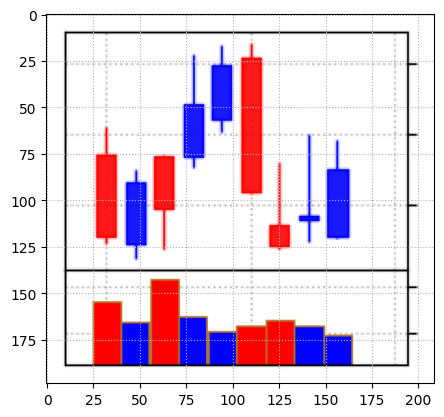

In [10]:
import cv2
a = cv2.imread(r'C:\Users\15ffg\Desktop\Lab\toss\data\targets\last\AAPL\AAPL_2023-09-13_to_2023-09-27_sample0001.png',cv2.IMREAD_COLOR)
plt.imshow(a)
plt.show()

In [1]:
import pandas as pd

df = pd.read_csv(r'C:\Users\15ffg\Desktop\Lab\toss\data\candlestick_data.csv')
df

,symbol,input_path,target_path,mode,up_or_down,change_rate
0,AAPL,data\inputs\random\AAPL\AAPL_2023-06-11_to_202...,data\targets\random\AAPL\AAPL_2023-06-11_to_20...,random,0;1,-0.0017112533364465965;0.016525306334115735
1,AAPL,data\inputs\last\AAPL\AAPL_2023-06-11_to_2023-...,data\targets\last\AAPL\AAPL_2023-06-11_to_2023...,last,0,-0.0017112533364465965
2,AAPL,data\inputs\random\AAPL\AAPL_2023-05-14_to_202...,data\targets\random\AAPL\AAPL_2023-05-14_to_20...,random,1;1,0.014104988337828629;0.006692155992959091
3,AAPL,data\inputs\last\AAPL\AAPL_2023-05-14_to_2023-...,data\targets\last\AAPL\AAPL_2023-05-14_to_2023...,last,1,0.014104988337828629
4,MSFT,data\inputs\random\MSFT\MSFT_2023-11-24_to_202...,data\targets\random\MSFT\MSFT_2023-11-24_to_20...,random,1;0,0.005829696775562332;-0.009986010327185697
...,...,...,...,...,...,...
97,SOXS,data\inputs\last\SOXS\SOXS_2023-02-03_to_2023-...,data\targets\last\SOXS\SOXS_2023-02-03_to_2023...,last,1,0.07320942795543141
98,SOXS,data\inputs\random\SOXS\SOXS_2023-12-03_to_202...,data\targets\random\SOXS\SOXS_2023-12-03_to_20...,random,0;0,-0.011254047217262333;-0.07851847258273609
99,SOXS,data\inputs\last\SOXS\SOXS_2023-12-03_to_2023-...,data\targets\last\SOXS\SOXS_2023-12-03_to_2023...,last,0,-0.011254047217262333
100,NVD,data\inputs\random\NVD\NVD_2024-06-03_to_2024-...,data\targets\random\NVD\NVD_2024-06-03_to_2024...,random,0;0,-0.04326923076923077;-0.06306306306306306


['-0.0532608457909635']


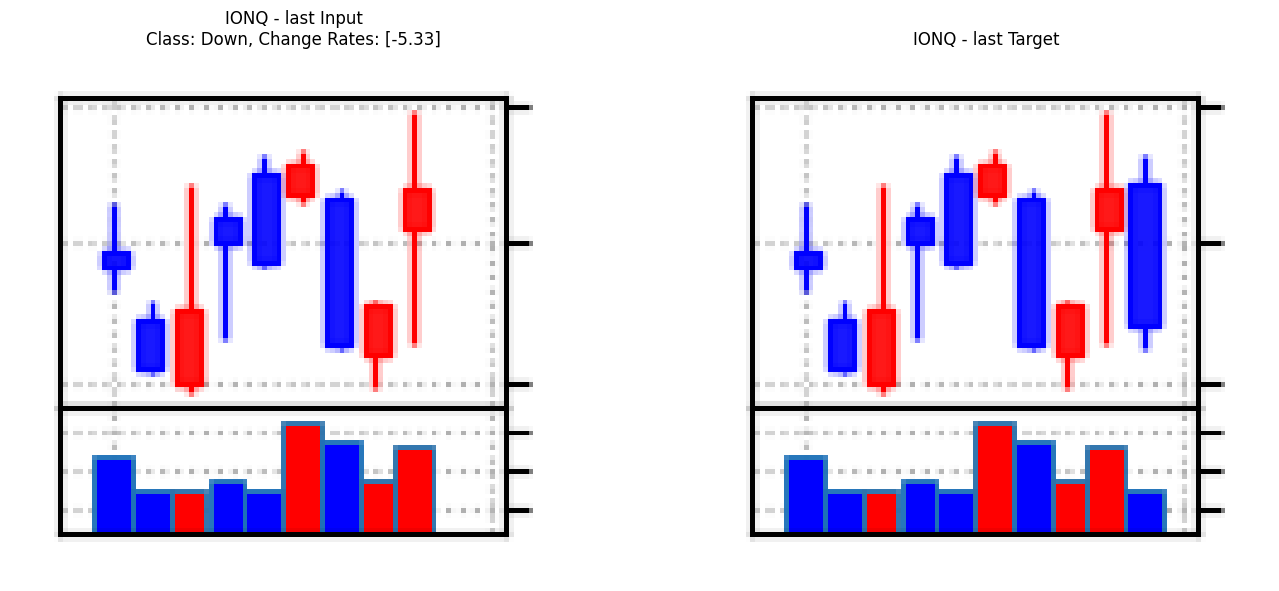

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def eda_single_sample(df, symbol, mode='random', sample_index=0):
    """
    특정 심볼과 모드의 input과 target을 시각화하고 분석하는 함수.

    Parameters:
    - df: 데이터프레임 (candlestick_data.csv에서 불러온 데이터)
    - symbol: 분석할 심볼 (예: 'AAPL')
    - mode: 'random' 또는 'last' 중 하나
    - sample_index: 해당 모드에서 분석할 샘플의 인덱스
    """
    # 주어진 조건에 맞는 데이터 필터링
    sample_df = df[(df['symbol'] == symbol) & (df['mode'] == mode)]
    
    if sample_index >= len(sample_df):
        print(f"Error: sample_index {sample_index} out of range for symbol '{symbol}' and mode '{mode}'")
        return

    # 선택된 샘플의 input 및 target 경로 가져오기
    input_path = sample_df.iloc[sample_index]['input_path']
    target_path = sample_df.iloc[sample_index]['target_path']
    up_or_down = sample_df.iloc[sample_index]['up_or_down']
    change_rates = sample_df.iloc[sample_index]['change_rate'].split(';')
    print(change_rates)
    change_rates = [round(float(rate) * 100,2) for rate in change_rates]  # 변동률을 % 단위로 변환
    
    # 이미지 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    idx2class = lambda x : 'Up' if x == 1 else 'Down'

    # Input 이미지 시각화
    try:
        input_image = mpimg.imread(input_path)
        axes[0].imshow(input_image)
        axes[0].set_title(f'{symbol} - {mode} Input\nClass: {idx2class(up_or_down)}, Change Rates: {change_rates}')
        axes[0].axis('off')
    except Exception as e:
        print(f"Error loading input image from {input_path}: {e}")
        return

    # Target 이미지 시각화
    try:
        target_image = mpimg.imread(target_path)
        axes[1].imshow(target_image)
        axes[1].set_title(f'{symbol} - {mode} Target')
        axes[1].axis('off')
    except Exception as e:
        print(f"Error loading target image from {target_path}: {e}")
        return

    plt.tight_layout()
    plt.show()

# 예시 사용법
df = pd.read_csv(r'C:\Users\15ffg\Desktop\Lab\toss\data\candlestick_data.csv')
eda_single_sample(df, symbol='IONQ', mode='last', sample_index=97)

5149
5149


<Axes: >

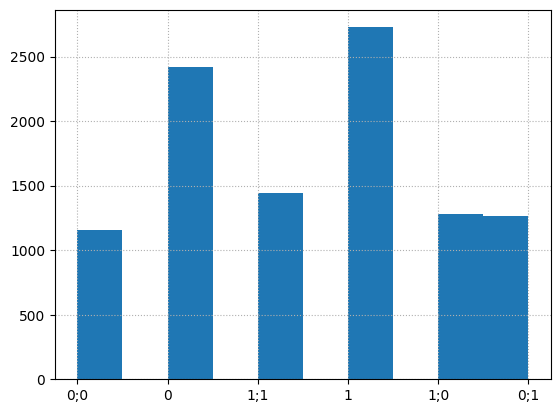

In [ ]:
print(df[df['mode']=='random'].__len__())
print(df[df['mode']=='last'].__len__())
df.up_or_down.hist() # class

5149

In [73]:
ap = lambda x : [float(_) for _ in x.split(';')]
df.head(5)

,symbol,input_path,target_path,mode,up_or_down,change_rate
0,AAPL,data\inputs\random\AAPL\AAPL_2023-10-07_to_202...,data\targets\random\AAPL\AAPL_2023-10-07_to_20...,random,0;0,-0.014704188861019308;-0.002161084723078167
1,AAPL,data\inputs\last\AAPL\AAPL_2023-10-07_to_2023-...,data\targets\last\AAPL\AAPL_2023-10-07_to_2023...,last,0,-0.014704188861019308
2,AAPL,data\inputs\random\AAPL\AAPL_2024-04-08_to_202...,data\targets\random\AAPL\AAPL_2024-04-08_to_20...,random,0;0,-0.012212514063506173;-0.00571440135062199
3,AAPL,data\inputs\last\AAPL\AAPL_2024-04-08_to_2024-...,data\targets\last\AAPL\AAPL_2024-04-08_to_2024...,last,0,-0.012212514063506173
4,AAPL,data\inputs\random\AAPL\AAPL_2023-09-26_to_202...,data\targets\random\AAPL\AAPL_2023-09-26_to_20...,random,1;1,0.008451175981276203;0.014750513737259711


In [20]:
import pandas as pd

df = pd.read_csv('data/candlestick_data.csv')
df[['input_path', 'target_path']]= df[['input_path', 'target_path']].applymap(lambda x : x.replace('\\','/'))
# df.to_csv('./candlestick_data_lnx.csv')

data load.
len : 5149


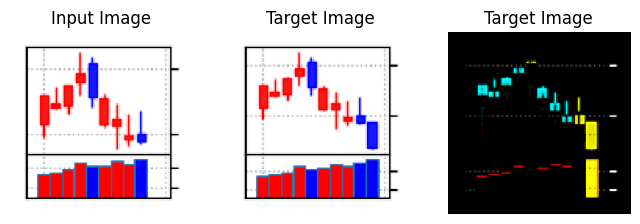

In [18]:
from finance_dataset import FinaceDataset
import matplotlib.pyplot as plt
import numpy as np
'''
dt returns 

data = {
        'image':input_tensor,
        'target_image':target_tensor,
        'up_or_down':torch.tensor(up_or_down,dtype=torch.long),
        'change_rate':torch.tensor(change_rate),
        # for analyze
        'mode':self.mode,
        'symbol':df.symbol
        }
'''

dt = FinaceDataset('data/candlestick_data_lnx.csv',mode='last')


sample = dt[0]

# Extract input and target tensors
input_tensor = sample['image']
target_tensor = sample['target_image']

# Convert tensors to NumPy for visualization (if needed)
input_np = input_tensor.permute(1, 2, 0).numpy()  # Assuming (C, H, W) format
target_np = target_tensor.permute(1, 2, 0).numpy()

# Visualize input tensor
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_np)
plt.title("Input Image")
plt.axis("off")

# Visualize target tensor
plt.subplot(1, 3, 2)
plt.imshow(target_np)
plt.title("Target Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.maximum(input_np-target_np,0))
plt.title("Target Image")
plt.axis("off")

plt.show()


(256, 256)


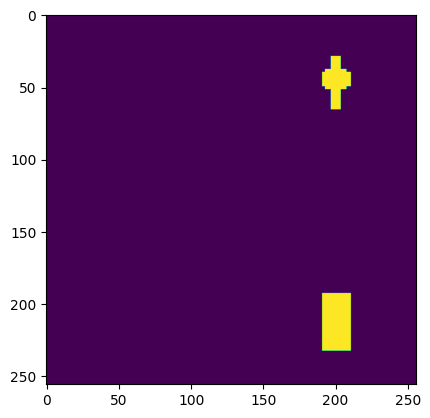

In [13]:
import numpy as np
import cv2

def create_binary_mask(input_image, target_image):
    # Ensure input and target images are the same shape
    if input_image.shape != target_image.shape:
        raise ValueError("Input and target images must have the same dimensions and number of channels.")
    
    input_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    target_gray = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
    
    # Generate binary mask: Compare pixels between input and target
    binary_mask = (input_gray != target_gray).astype(np.uint8)
    
    return binary_mask
a = create_binary_mask(input_np,target_np)
print(a.shape)
plt.imshow(a)

In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.0.1+cu118
11.8
True


In [ ]:
def display_hsv_values(image_hsv):
    print(image_hsv[:, :, 1].shape)
    print(image_hsv.shape)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Hue Channel")
    plt.imshow(image_hsv[:, :, 0], cmap="hsv")
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.title("Saturation Channel")
    plt.imshow(image_hsv[:, 191:, 1], cmap="gray")
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.title("Value Channel")
    plt.imshow(image_hsv[:, :, 2], cmap="gray")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

display_hsv_values(hsv)

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

def read_and_split_data(file_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_state=42):
    """
    Reads a CSV file, counts the total number of rows, and splits the data into train, validation, and test sets.
    
    Args:
        file_path (str): Path to the CSV file.
        train_ratio (float): Proportion of the data to be used for training.
        val_ratio (float): Proportion of the data to be used for validation.
        test_ratio (float): Proportion of the data to be used for testing.
        random_state (int): Seed for reproducibility.
        
    Returns:
        tuple: train, val, test DataFrames, and total row count.
    """
    # Load the data
    data = pd.read_csv(file_path)
    
    # Calculate total rows
    total_rows = len(data)
    
    # Split the data into train and temp
    train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=random_state)
    
    # Split the temp data into validation and test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation ratio for temp split
    val_data, test_data = train_test_split(temp_data, train_size=val_ratio_adjusted, random_state=random_state)
    
    return train_data, val_data, test_data, total_rows


def save_splits(train_data, val_data, test_data, output_dir="splits"):
    """
    Saves the train, val, and test splits as separate CSV files.
    
    Args:
        train_data (pd.DataFrame): Training data.
        val_data (pd.DataFrame): Validation data.
        test_data (pd.DataFrame): Testing data.
        output_dir (str): Directory to save the splits.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save each split as a CSV file
    train_data.to_csv(os.path.join(output_dir, "train.csv"), index=False)
    val_data.to_csv(os.path.join(output_dir, "val.csv"), index=False)
    test_data.to_csv(os.path.join(output_dir, "test.csv"), index=False)
    
    print(f"Splits saved to directory: {output_dir}")


if __name__ == "__main__":
    file_path = "/workspace/fi_homework/data/candlestick_data_lnx_2.csv"
    
    # Read and split the data
    train_data, val_data, test_data, total_rows = read_and_split_data(file_path)
    
    # Save the splits
    save_splits(train_data, val_data, test_data)
    
    print(f"Total rows: {total_rows}")
    print(f"Train rows: {len(train_data)}")
    print(f"Validation rows: {len(val_data)}")
    print(f"Test rows: {len(test_data)}")


Splits saved to directory: splits
Total rows: 10298
Train rows: 7208
Validation rows: 2060
Test rows: 1030


In [4]:
import pandas as pd
pd.read_csv('/workspace/fi_homework/data/candlestick_data_lnx.csv',index_col=0).to_csv('/workspace/fi_homework/data/candlestick_data_lnx_2.csv',index=False)
